# Cox regression to predict immunotherapy response
In this notebook, we use the Cox regression model to estimate the probability of surviving and the probability of no disease's progression. 

## Plan :
1. Reading the dataset
2. Training the model using leave one out cross validation
3. Predicting survival curves and evaluate the model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from models.CoxModel import CoxModel
from utils.preProcessing import preProcessing

In [2]:
preprocessor = preProcessing()

## 1. Reading the dataset
We use the dataset from the following article : https://doi.org/10.1158/1078-0432.CCR-20-1163. We only keep naive patients.

In [3]:
df = pd.read_excel('data/Supplemental-table1.xlsx')
df = df.loc[df["Cohort"] == "Naive"]
df

,Anonymous ID,EGA ID,Tumour type,Sex,Line of therapy,Immunotherapy regimen,Cohort,Reason for discontinuation,Best response,Age at advanced disease diagnosis,...,Alive_0,Time to progression (days),Progression_1,Clinical benefit,CD8+ T cell score,Exome mut per mb,Genome mut per mb,CD274 expression,M1M2 expression,Lymph related
0,14891,EGAD00001001961,LUNG,F,8,Nivolumab,Naive,Progression,Mixed,45,...,1,179,1,NCB,0.351869,11.095310,23.0729,4.1689,55.51575,Non-lymph related
1,18624,EGAD00001002047,AECA,F,10,Nivolumab,Naive,Progression,Stable disease,47,...,1,148,1,NCB,0.071464,3.876336,5.4552,0.7910,9.32352,Non-lymph related
2,21392,EGAD00001002544,OV,F,6,Monalizumab,Naive,Progression,Physician assessed SD,57,...,1,79,1,NCB,0.040394,2.415688,4.1274,4.0377,50.12008,Lymph related
3,21516,EGAD00001002546,SKCM,F,3,Ipilimumab,Naive,Death,Not evaluable,29,...,1,11,0,NCB,0.052774,6.235845,11.4871,0.6006,1.58550,Non-lymph related
4,22186,EGAD00001001966,LUNG,F,4,Atezolizumab,Naive,Progression,Stable disease,52,...,1,80,1,NCB,0.009323,4.606660,7.1503,1.8234,38.42695,Non-lymph related
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,39280,EGAD00001004933,LUNG,M,2,Pembrolizumab,Naive,Toxicity,Physician Assessed SD,60,...,1,401,0,DCB,0.695396,84.998501,96.4079,8.4768,86.62561,Non-lymph related
94,37899,EGAD00001005838,CHOL,F,2,Nivolumab,Naive,Death,Physician assessed PR,38,...,1,96,0,NCB,0.818233,2.247151,2.7416,11.2704,47.97376,Non-lymph related
95,37775,EGAD00001004934,HNSC,M,1,Avelumab/OX40 agonist PF-04518600,Naive,Progression,Stable disease,69,...,1,69,1,NCB,0.018982,3.848247,5.8036,8.7136,5.13403,Non-lymph related
96,38313,EGAD00001005844,ACC,F,3,Avelumab/Debio1143 (SMAC mimetic),Naive,Toxicity,Partial response,34,...,1,51,1,NCB,0.000000,5.617878,7.7940,0.0688,0.51364,Non-lymph related


## 2. Training the model using leave one out cross validation
The Cox regression model estimates the risk score. With the leave one out cross validation, we train the model for all the patients except one, next we select a risk cutoff, and then we predict the risk class of the test patient (1 if high risk, 0 otherwise).

In [4]:
# Select features matrix and label vectors (TTP and OS)
X = df.loc[:,["Age at advanced disease diagnosis","CD8+ T cell score","Genome mut per mb","Exome mut per mb","CD274 expression","M1M2 expression"]].to_numpy()
y_ttp = np.array(list((df[['Progression_1','Time to progression (days)']].itertuples(index=False, name=None))),dtype=[('Progression_1', '?'), ('Time to progression (days)', '<f8')])
y_os = np.array(list((df[['Alive_0','Overall survival (days)']].itertuples(index=False, name=None))),dtype=[('Alive_0', '?'), ('Overall survival (days)', '<f8')])

# Normalize the dataset
X = preprocessor.normalize_data(X)

# Instanciate the Cox Model
cox = CoxModel()

# Find the risk classes
# TTP
risk_classes_ttp, risk_scores_ttp = cox.leave_one_out_cross_validation(X,y_ttp)
print("TTP :")
print(f"n_samples high risk : {np.where(risk_classes_ttp==1)[0].shape[0]}")
print(f"n_samples low risk : {np.where(risk_classes_ttp==0)[0].shape[0]}\n")

# OS
print("OS :")
risk_classes_os, risk_scores_os = cox.leave_one_out_cross_validation(X,y_os)
print(f"n_samples high risk : {np.where(risk_classes_os==1)[0].shape[0]}")
print(f"n_samples low risk : {np.where(risk_classes_os==0)[0].shape[0]}")

TTP :
n_samples high risk : 44
n_samples low risk : 38

OS :
n_samples high risk : 42
n_samples low risk : 40


## 3. Predicting survival curves and evaluate the model
Now, with the trained Cox model, we plot the probability of surviving along time and the probability of no progression along time for each risk class. Besides, for each metric (TTP and OS), we compute the C-index for the classification (which is the equivalent of AUC in survival analysis) and the p value of the log rank test (if p is low, the 2 curves are significantly differents).

### a. C-index

In [5]:
# TTP : 
status_ttp, time_ttp = df['Progression_1'].to_numpy().astype(bool), df['Time to progression (days)'].to_numpy()
c_index_ttp = cox.get_c_index(status_ttp, time_ttp, risk_scores_ttp)

# OS :
status_os, time_os = df['Alive_0'].to_numpy().astype(bool), df['Overall survival (days)'].to_numpy()
c_index_os = cox.get_c_index(status_os, time_os, risk_scores_os)

### b. p value

In [6]:
# TTP :
p_value_ttp = cox.log_rank_test(status_ttp.astype(int), time_ttp, risk_classes_ttp)

# OS :
p_value_os = cox.log_rank_test(status_os.astype(int), time_os, risk_classes_os)

### c. Plot survival curves

In [7]:
# Split low risk group and high risk group

# TTP :
# Low risk class
status_low_ttp, time_low_ttp = status_ttp[np.where(risk_classes_ttp==0)], time_ttp[np.where(risk_classes_ttp==0)]
time_axis_low_ttp, prob_axis_low_ttp = cox.kaplan_meier_estimation(status_low_ttp, time_low_ttp)
# High risk class
status_high_ttp, time_high_ttp = status_ttp[np.where(risk_classes_ttp==1)], time_ttp[np.where(risk_classes_ttp==1)]
time_axis_high_ttp, prob_axis_high_ttp = cox.kaplan_meier_estimation(status_high_ttp, time_high_ttp)

# OS :
# Low risk class
status_low_os, time_low_os = status_os[np.where(risk_classes_os==0)], time_os[np.where(risk_classes_os==0)]
time_axis_low_os, prob_axis_low_os = cox.kaplan_meier_estimation(status_low_os, time_low_os)
# High risk class
status_high_os, time_high_os = status_os[np.where(risk_classes_os==1)], time_os[np.where(risk_classes_os==1)]
time_axis_high_os, prob_axis_high_os = cox.kaplan_meier_estimation(status_high_os, time_high_os)

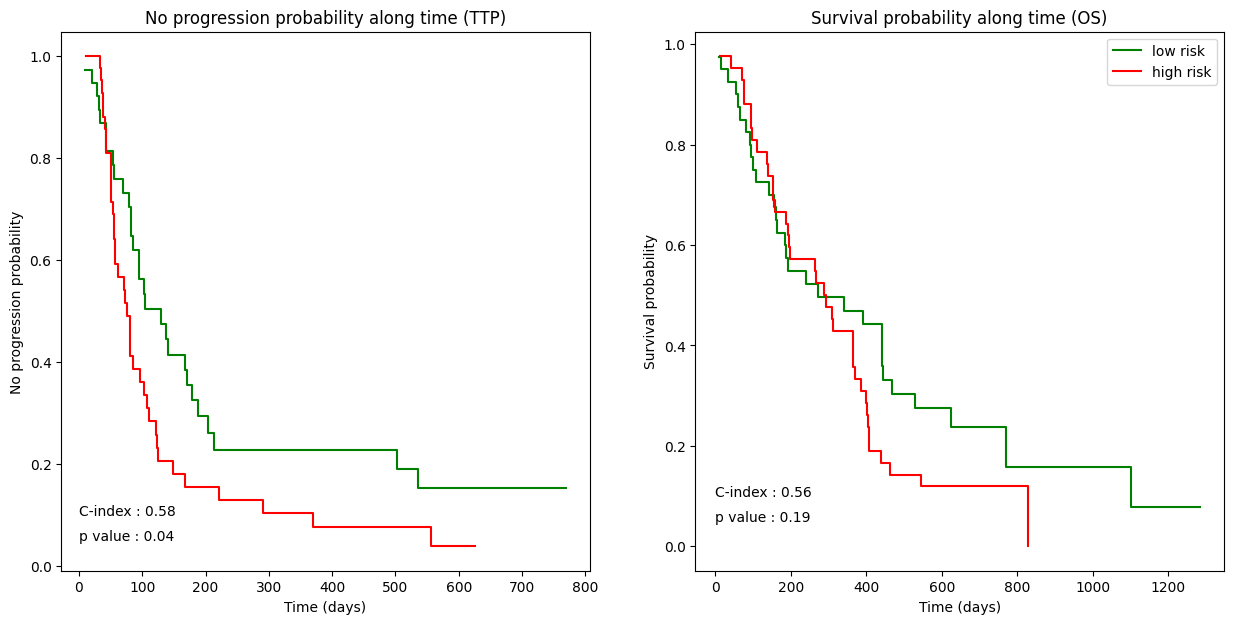

In [8]:
# Plot

fig, ax = plt.subplots(1,2,figsize=(15,7))
ax[0].step(time_axis_low_ttp, prob_axis_low_ttp, where='post',color='green',label='low risk')
ax[0].step(time_axis_high_ttp, prob_axis_high_ttp, where='post',color='red',label='high risk')
ax[0].set_xlabel('Time (days)')
ax[0].set_ylabel('No progression probability')
ax[0].set_title('No progression probability along time (TTP)')
ax[0].text(0,0.1,f'C-index : {c_index_ttp}')
ax[0].text(0,0.05,f'p value : {p_value_ttp}')

ax[1].step(time_axis_low_os, prob_axis_low_os, where='post',color='green',label='low risk')
ax[1].step(time_axis_high_os, prob_axis_high_os, where='post',color='red',label='high risk')
ax[1].set_xlabel('Time (days)')
ax[1].set_ylabel('Survival probability')
ax[1].set_title('Survival probability along time (OS)')
ax[1].text(0,0.1,f'C-index : {c_index_os}')
ax[1].text(0,0.05,f'p value : {p_value_os}')

plt.legend()
plt.savefig('km-survival-curve.png')